### Abrindo o vídeo e mostrando o vídeo

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib.use('TkAgg')
#removido para a plotagem dos gráficos
import imageio
from IPython import display
from time import sleep
#import matplotlib.pyplot as plt

import pims
from PIL import Image

imageio.plugins.ffmpeg.download()

v_depth = pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_08_48_35FrontDepth.avi')
v_color = pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_08_48_35FrontColor.avi')

v2_depth = pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_07_15_44FrontDepth.avi')
v2_color = pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_07_15_44FrontColor.avi')

v3_depth = pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_19_09_56FrontDepth.avi')
v3_color = pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_19_09_56FrontColor.avi')

v4_depth = pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_18_58_34FrontDepth.avi')
v4_color = pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_18_58_34FrontColor.avi')

v5_depth = pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_14_37_58FrontDepth.avi')
v5_color = pims.Video('../dataset/25_20160407_front/normal/crowd/2016_04_07_14_37_58FrontColor.avi')

In [2]:
def play(video):
    
    fig = plt.figure()
    ax = fig.gca()
    fig.show()

    for ii in range(len(video)):
        im = video[ii]
        plt.imshow(im, cmap='gray')
        ax.set_title(ii)

        fig.canvas.draw()
        sleep(0.1)

In [3]:
def to_gray(video):
    frames, width, hight, color = video.shape
    video_gray = np.zeros((frames, width, hight), dtype='uint32')
    
    for ii in range(len(video)):
        r, g, b = Image.fromarray(video[ii]).split()
        
        r = np.array(r, dtype='uint32')
        g = np.array(g, dtype='uint32')
        b = np.array(b, dtype='uint32')
        
        video_gray[ii] = (r + g + b) / 3
        
    return video_gray

In [4]:
def integra(x):
    s=np.sum(x,axis=1)
    s=np.sum(s,axis=1)
    return s

In [15]:
def conta_integral(x):
    x_cropped=x[:,100:240,0:125]
    integral=integra(x_cropped)
    integral=integral/np.max(integral)
    plt.figure()
    plt.plot(integral)
    limiar=np.min(integral)+((np.max(integral)-np.min(integral))/2)
    plt.plot(limiar*np.ones(integral.shape),'-r')
    info_binaria=integral<limiar
    plt.figure()
    plt.plot(info_binaria)
    picos=np.bitwise_and(info_binaria,np.invert(np.roll(info_binaria,1)))
    pessoas=np.count_nonzero(picos)
    frames_ind=np.nonzero(picos)
    return pessoas,frames_ind

In [6]:
def conta_integral_explore(x,valor_real,num):
    x_cropped=x[:,100:240,0:125]
    integral=integra(x_cropped)
    integral=integral/np.max(integral)
    ref=np.min(integral)+((np.max(integral)-np.min(integral))/2)
    limiar_list=np.arange(ref-0.15,ref+0.15,0.01)
    pessoas=np.zeros(len(limiar_list))
    for i,limiar in enumerate(limiar_list):
        info_binaria=integral<limiar
        picos=np.bitwise_and(info_binaria,np.invert(np.roll(info_binaria,1)))
        pessoas[i]=np.count_nonzero(picos)
    tx_erro=np.abs(np.subtract(pessoas,valor_real))/valor_real
    plt.figure(figsize=(8,6))
    plt.plot(limiar_list,tx_erro,'.-')
    plt.plot(limiar_list[15],tx_erro[15],'Dr')
    plt.title("Taxa de erro do vídeo %i" %num)
    
    return tx_erro

In [7]:
x1 = to_gray(np.array(v_depth))
x2 = to_gray(np.array(v2_depth))
x3 = to_gray(np.array(v3_depth))
x4 = to_gray(np.array(v4_depth))
x5 = to_gray(np.array(v5_depth))

y1 = to_gray(np.array(v_color))
y2 = to_gray(np.array(v2_color))
y3 = to_gray(np.array(v3_color))
y4 = to_gray(np.array(v4_color))
y5 = to_gray(np.array(v5_color))

X=[x1,x2,x3,x4,x5]
Y=[y1,y2,y3,y4,y5]

valor_real=[7,7,10,13,20]


O numero de pessoas contado foi:  10
CPU times: user 192 ms, sys: 6.68 ms, total: 198 ms
Wall time: 197 ms


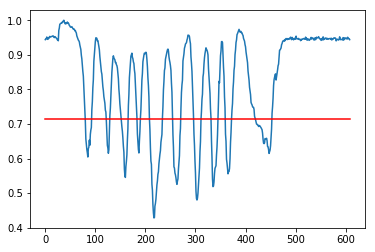

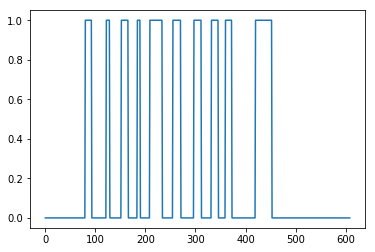

In [18]:
%%time
[pessoas,frames]=conta_integral(X[2])
print("O numero de pessoas contado foi: ",pessoas)

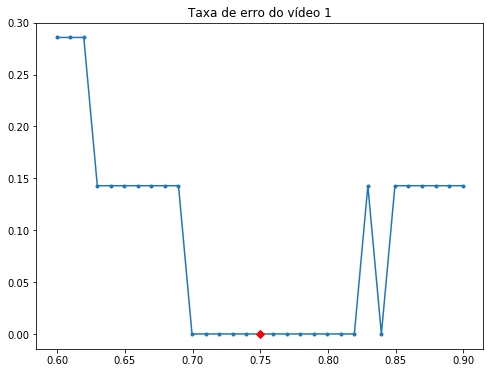

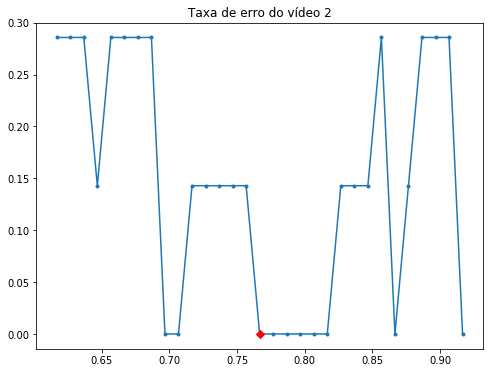

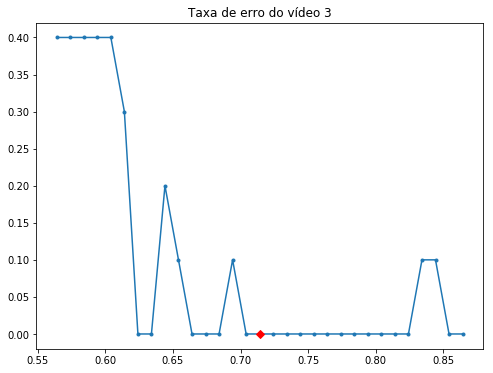

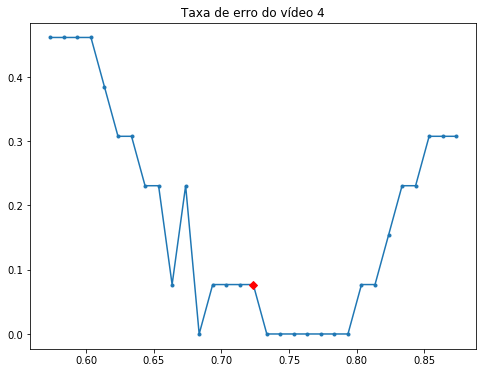

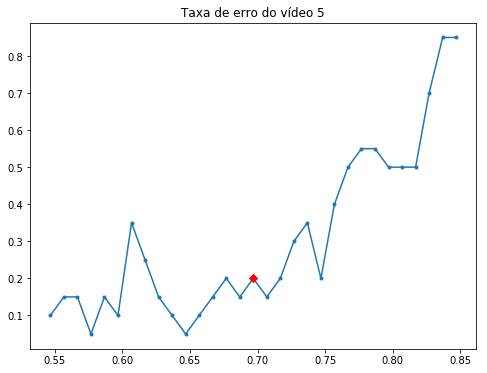

In [8]:
tx_erro=np.zeros((5,31))
for i,x in enumerate(X):
    tx_erro[i,:]=conta_integral_explore(x,valor_real[i],i+1)


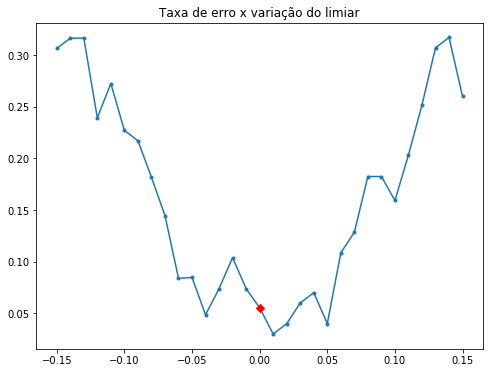

In [9]:
tx_media=np.average(tx_erro,axis=0)
var_limiar=np.arange(-0.15,0.16,0.01)
plt.figure(figsize=(8,6))
plt.title('Taxa de erro x variação do limiar')
plt.plot(var_limiar,tx_media,'.-')
plt.plot(var_limiar[15],tx_media[15],'Dr')


